# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2015


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2015-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    105,982    4,078   2,355   1,948   2,424
  1           9thStreet    118,812    4,186   3,396   2,892   3,274
  2          14thStreet    219,205    8,159   5,456   4,326   5,718
  3          23rdStreet    189,374    7,990   2,756   2,183   3,526
  4          33rdStreet    816,970   32,345  15,493  12,226  21,846
  5     UPTOWN SUBTOTAL  1,450,343   56,758  29,456  23,575  36,788
  6                 WTC    974,660   43,725   8,982   6,681  14,260
  7   NEW YORK SUBTOTAL  2,425,003  100,483  38,438  30,256  51,048,
                       0          1        2       3       4        5
  0               Newark    583,729   25,190   7,850   5,559    9,216
  1             Harrison    153,038    6,604   2,052   1,380    2,591
  2       Journal Square    588,006   23,413  11,865   8,828   12,552
  3         Grove Street    392,516   15,937   7,587   5,301    7,320
  4       Exchange Place    307,46

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

0          1        2        3       4       5  \
0    Christopher Street    105,982    4,078    2,355   1,948   2,424   
1             9thStreet    118,812    4,186    3,396   2,892   3,274   
2            14thStreet    219,205    8,159    5,456   4,326   5,718   
3            23rdStreet    189,374    7,990    2,756   2,183   3,526   
4            33rdStreet    816,970   32,345   15,493  12,226  21,846   
..                  ...        ...      ...      ...     ...     ...   
4        Exchange Place    364,150   15,121    4,201   2,998   2,682   
5      Pavonia/ Newport    488,059   18,522   10,578   7,896   6,667   
6               Hoboken    691,231   26,712   14,618  10,231   4,178   
7   NEW JERSEY SUBTOTAL  3,596,364  139,199   71,512  52,039  39,773   
8         MONTHLY TOTAL  6,432,413  248,435  125,486  97,921  73,223   

          date  
0   2015-01-01  
1   2015-01-01  
2   2015-01-01  
3   2015-01-01  
4   2015-01-01  
..         ...  
4   2015-12-01  
5   2015-12-01  
6   2015-12-01  
7   2015-12-01  
8   2015-12-01  

[204 rows x 7 columns]

In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

station    total  avg weekday  avg sat  avg sun  avg holiday  \
0    Christopher Street   105982         4078     2355     1948         2424   
1             9thStreet   118812         4186     3396     2892         3274   
2            14thStreet   219205         8159     5456     4326         5718   
3            23rdStreet   189374         7990     2756     2183         3526   
4            33rdStreet   816970        32345    15493    12226        21846   
..                  ...      ...          ...      ...      ...          ...   
4        Exchange Place   364150        15121     4201     2998         2682   
5      Pavonia/ Newport   488059        18522    10578     7896         6667   
6               Hoboken   691231        26712    14618    10231         4178   
7   NEW JERSEY SUBTOTAL  3596364       139199    71512    52039        39773   
8         MONTHLY TOTAL  6432413       248435   125486    97921        73223   

         month  
0   2015-01-01  
1   2015-01-01  
2   2015-01-01  
3   2015-01-01  
4   2015-01-01  
..         ...  
4   2015-12-01  
5   2015-12-01  
6   2015-12-01  
7   2015-12-01  
8   2015-12-01  

[204 rows x 7 columns]

In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

station  avg daily  total weekday  total sat  total sun  \
0    Christopher Street       3419          81568      11774       7793   
1             9thStreet       3833          83718      16979      11567   
2            14thStreet       7071         163189      27279      17302   
3            23rdStreet       6109         159810      13779       8733   
4            33rdStreet      26354         646908      77466      48904   
..                  ...        ...            ...        ...        ...   
4        Exchange Place      11747         332670      16804      11994   
5      Pavonia/ Newport      15744         407495      42311      31586   
6               Hoboken      22298         587658      58472      40923   
7   NEW JERSEY SUBTOTAL     116012        3062387     286046     208158   
8         MONTHLY TOTAL     207497        5465563     501943     391684   

    total holiday       month  
0            4847  2015-01-01  
1            6548  2015-01-01  
2           11435  2015-01-01  
3            7052  2015-01-01  
4           43692  2015-01-01  
..            ...         ...  
4            2682  2015-12-01  
5            6667  2015-12-01  
6            4178  2015-12-01  
7           39773  2015-12-01  
8           73223  2015-12-01  

[204 rows x 7 columns]

In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2015-01-01 Christopher Street        3419         4078     2355     1948   
           9thStreet                 3833         4186     3396     2892   
           14thStreet                7071         8159     5456     4326   
           23rdStreet                6109         7990     2756     2183   
           33rdStreet               26354        32345    15493    12226   
...                                   ...          ...      ...      ...   
2015-12-01 Exchange Place           11747        15121     4201     2998   
           Pavonia/ Newport         15744        18522    10578     7896   
           Hoboken                  22298        26712    14618    10231   
           NEW JERSEY SUBTOTAL     116012       139199    71512    52039   
           MONTHLY TOTAL           207497       248435   125486    97921   

                                avg holiday    total  total weekday  \
month      station                                                    
2015-01-01 Christopher Street          2424   105982          81568   
           9thStreet                   3274   118812          83718   
           14thStreet                  5718   219205         163189   
           23rdStreet                  3526   189374         159810   
           33rdStreet                 21846   816970         646908   
...                                     ...      ...            ...   
2015-12-01 Exchange Place              2682   364150         332670   
           Pavonia/ Newport            6667   488059         407495   
           Hoboken                     4178   691231         587658   
           NEW JERSEY SUBTOTAL        39773  3596364        3062387   
           MONTHLY TOTAL              73223  6432413        5465563   

                                total sat  total sun  total holiday  
month      station                                                   
2015-01-01 Christopher Street       11774       7793           4847  
           9thStreet                16979      11567           6548  
           14thStreet               27279      17302          11435  
           23rdStreet               13779       8733           7052  
           33rdStreet               77466      48904          43692  
...                                   ...        ...            ...  
2015-12-01 Exchange Place           16804      11994           2682  
           Pavonia/ Newport         42311      31586           6667  
           Hoboken                  58472      40923           4178  
           NEW JERSEY SUBTOTAL     286046     208158          39773  
           MONTHLY TOTAL           501943     391684          73223  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

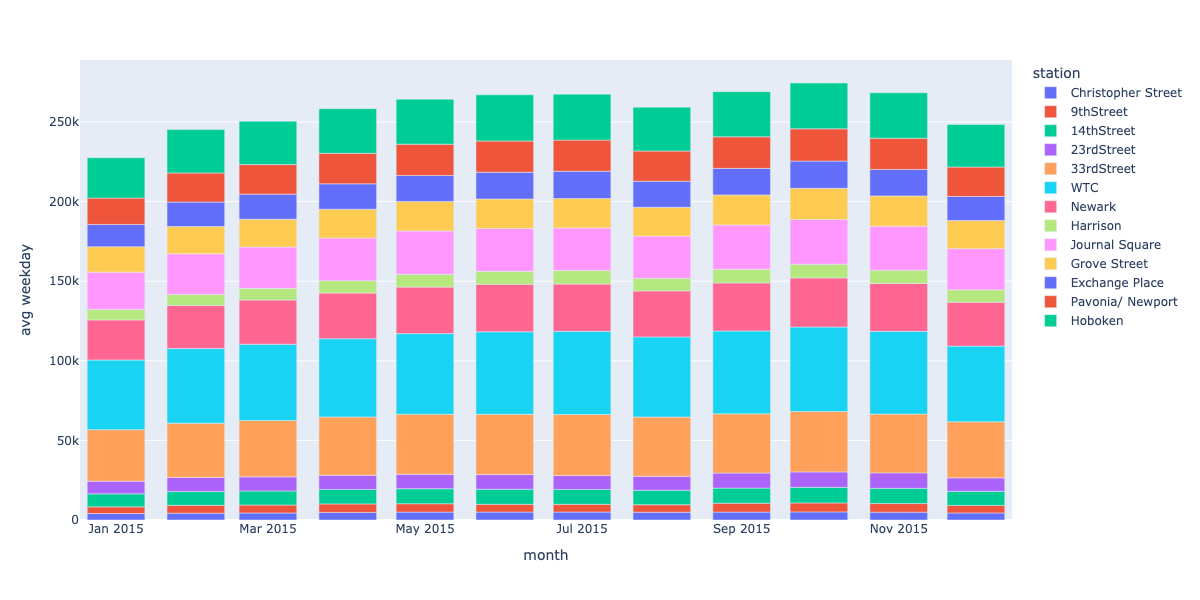

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))